In [55]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import keras.backend as K
# import xgboost as xgb
import os

from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model  
from keras.layers.core import Dense, Activation  
from keras.layers import Input, Dense, LSTM, Flatten, Dropout, Reshape, GRU,\
                         Conv1D, MaxPooling1D, Convolution1D,\
                         Convolution2D, MaxPooling2D,\
                         Convolution3D, MaxPooling3D
from keras.models import Sequential
# from keras.layers import Input, Dense, LSTM, Flatten, Reshape
from keras.models import Model
from keras.preprocessing import sequence
# from keras.optimizers import Nadam
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping


%matplotlib inline

In [42]:
def filter_range(X, Y, limit=15):
    resX=[]
    resY=[]
    for i in range(len(Y)):
        if (Y[i]>limit):
            continue
        resX.append(X[i])
        resY.append(Y[i])
    resX = np.array(resX)
    resY = np.array(resY)
    return (resX, resY)

In [43]:
data_dir = '../data2/f_D100_ush'

X_training = np.load(os.path.join(data_dir, "X_train.npy"))#"../data2/X_train_f100.npy")
Y_training = np.load(os.path.join(data_dir, "Y_train.npy"))#"../data2/Y_train_f100.npy")

X_val = np.load(os.path.join(data_dir, "X_val.npy"))#"../data2/X_val_f100.npy")
Y_val = np.load(os.path.join(data_dir, "Y_val.npy"))#"../data2/Y_val_f100.npy")

X_testing = np.load(os.path.join(data_dir, "X_test.npy"))#"../data2/X_test_f100.npy")
Y_testing = np.load(os.path.join(data_dir, "Y_test.npy"))#"../data2/Y_test_f100.npy")


X_training = np.concatenate( (X_training, X_val), axis=0 )
Y_training = np.concatenate( (Y_training, Y_val), axis=0 )


X_training, Y_training = filter_range(X_training, Y_training)
X_val, Y_val = filter_range(X_val, Y_val)
X_testing, Y_testing = filter_range(X_testing, Y_testing)


print("Train: ",np.max(Y_training), np.min(Y_training))
print("Test: ",np.max(Y_testing), np.min(Y_testing))

# Centering and Normalizing data
mux = np.mean(X_training, axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_val = (X_val - mux)/stdx
X_testing = (X_testing - mux)/stdx

Train:  15.0 2.94
Test:  12.3 3.2


In [79]:
def get_model(data_dim, time_steps):
    nb_filters = 200
    
    ip_shape = (time_steps, data_dim, 1)
    inputs = Input(shape = ip_shape)
    
    conv_1 = Convolution2D(filters = 32, kernel_size = 5, strides=(1,1), padding="same",
                    activation='relu', name="Conv1")(inputs)
    batch_norm1 = BatchNormalization( name = "batch_norm_1")(conv_1)
    maxpool_1 = MaxPooling2D(pool_size=(1,7), padding="same", name="maxpool1")(batch_norm1)
    
    conv_2 = Convolution2D(filters = 16, kernel_size = 5, strides=(1,1), padding="same",
                     activation='relu', name="Conv2")(maxpool_1)
    batch_norm2 = BatchNormalization( name = "batch_norm_2")(conv_2)
    maxpool_2 = MaxPooling2D(pool_size=(1,3), padding="same", name="maxpool2")(batch_norm2)
    
    conv_3 = Convolution2D(filters = 1, kernel_size = (1,3), strides=(1,1), padding="same",
                     activation='relu', name="Conv3")(batch_norm2)
    batch_norm3 = BatchNormalization( name = "batch_norm_3")(conv_3)
    maxpool_3 = MaxPooling2D(pool_size=(1,1), padding="same", name="maxpool3")(batch_norm3)
    layer_shape = maxpool_3._keras_shape
    maxpool_3 = Reshape(target_shape=(layer_shape[1], layer_shape[2]*layer_shape[3]),
                        name="maxpool3_RS")(maxpool_3)
    
#     flatten = Flatten()(maxpool_3)
    
    lstm_1 = LSTM(32, return_sequences=True, name="lstm_1")(maxpool_3)
#     lstm_2 = LSTM(128, return_sequences="True", name="lstm_2")(lstm_1)
    
    flatten = Flatten()(lstm_1)
    
    
#     lstm_1 = GRU(32)(maxpool_3)
    
    dense_1 = Dense(64, activation='relu', name="Dense1")(flatten)
    batch_norm4 = BatchNormalization( name = "batch_norm_4")(dense_1)
    dropout_1 = Dropout(0.4, name="dropout_1")(batch_norm4)
    
    dense_2 = Dense(32, activation='relu', name="Dense2")(dropout_1)
    batch_norm5 = BatchNormalization( name = "batch_norm_5")(dense_2)
    dropout_2 = Dropout(0.4, name="dropout_2")(batch_norm5)
    
    output = Dense(1, name="output")(dropout_1)
    model = Model(inputs = inputs, output = output)
    
    return model

In [80]:
data_dim = X_training.shape[1]
time_steps = 20
x=get_model(data_dim, time_steps)
x.compile(optimizer="Adam", loss="mean_squared_error")
x.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 20, 100, 1)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 20, 100, 32)       832       
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 20, 100, 32)       128       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 20, 15, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 20, 15, 16)        12816     
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 20, 15, 16)        64        
_________________________________________________________________
Conv3 (Conv2D)               (None, 20, 15, 1)         49        
__________

C:\Users\aksha\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [44]:
def create_dataset(X, Y, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(X)-time_steps-1):
        a = X[i:(i+time_steps)]
        dataX.append(a)
        a = Y[(i+time_steps)]
        dataY.append(a)  #dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [45]:
time_steps = 
trainX, trainY = create_dataset(X_training, Y_training, time_steps)
valX, valY = create_dataset(X_val, Y_val, time_steps)
testX, testY = create_dataset(X_testing, Y_testing, time_steps)

In [8]:
print(X_training.shape, Y_training.shape)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)
print(valX.shape, valY.shape)

(8050, 100) (8050,)
(8039, 10, 100) (8039,)
(1303, 10, 100) (1303,)
(7935, 10, 100) (7935,)


In [81]:
n_epochs = 50
data_dim = X_training.shape[1]
batch_size = 100
L=len(X_training)
n_Iter = int(L/batch_size)
# results = {}

T_range = [20]#[1, 2, 5, 10, 15, 20, 30, 50, 75, 100]
for time_steps in T_range:
    trainX, trainY = create_dataset(X_training, Y_training, time_steps)
    valX, valY = create_dataset(X_val, Y_val, time_steps)
    testX, testY = create_dataset(X_testing, Y_testing, time_steps)

    optimizer = optimizers.Nadam(lr=1e-4)#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)
    model = get_model(data_dim, time_steps)
    model.compile(loss="logcosh", optimizer=optimizer)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20,
                              verbose=1, mode='auto')
    callbacks_list = [earlystop]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2], 1))
    valX = np.reshape(valX, (valX.shape[0], valX.shape[1], valX.shape[2], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2], 1))
    
    model.fit(x=trainX, y=trainY, batch_size=batch_size, epochs=100,
          validation_data=(testX, testY),
          callbacks=callbacks_list)
    
    preds = model.predict(testX)
    rmse = np.sqrt(mean_squared_error(preds, testY))
    mre = rmse*100.0/(np.max(testY) - np.min(testY))
    print("Time Steps:", time_steps, "\tTest RMSE:", rmse, "\tTest  MRE:", mre,"%" )
    results[time_steps] = {"RMSE": rmse,
                           "MRE": mre}
    
    
    # val_data = (np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)), Y_val)
    # Y_train = np.reshape( Y_training, (L, 1, 1) )
    # X_train = np.reshape( X_training, (L, X_training.shape[1], 1) )

C:\Users\aksha\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


Train on 27628 samples, validate on 1752 samples
Epoch 1/100
27628/27628 [==============================] - 23s 834us/step - loss: 10.0795 - val_loss: 6.9168
Epoch 2/100
27628/27628 [==============================] - 14s 499us/step - loss: 9.7490 - val_loss: 5.7668
Epoch 3/100
27628/27628 [==============================] - 14s 517us/step - loss: 9.3327 - val_loss: 5.8670
Epoch 4/100
27628/27628 [==============================] - 14s 510us/step - loss: 8.7539 - val_loss: 4.5243
Epoch 5/100
27628/27628 [==============================] - 14s 507us/step - loss: 8.0315 - val_loss: 2.6751
Epoch 6/100
27628/27628 [==============================] - 14s 504us/step - loss: 7.1348 - val_loss: 4.6227
Epoch 7/100
27628/27628 [==============================] - 14s 506us/step - loss: 6.0932 - val_loss: 2.0118
Epoch 8/100
27628/27628 [==============================] - 14s 522us/step - loss: 4.9482 - val_loss: 1.0120
Epoch 9/100
27628/27628 [==============================] - 14s 508us/step - loss: 3.81

In [57]:
model.fit(x=trainX, y=trainY, batch_size=batch_size, epochs=50,
#           validation_split=0.3,
          validation_data=(testX, testY)),
#           callbacks=callbacks_list)

Train on 27628 samples, validate on 1752 samples
Epoch 1/50
27628/27628 [==============================] - 14s 491us/step - loss: 1.4605 - val_loss: 2.1536
Epoch 2/50
27628/27628 [==============================] - 13s 484us/step - loss: 1.4338 - val_loss: 2.4665
Epoch 3/50
27628/27628 [==============================] - 13s 487us/step - loss: 1.4166 - val_loss: 2.1132
Epoch 4/50
27628/27628 [==============================] - 13s 481us/step - loss: 1.3958 - val_loss: 1.9191
Epoch 5/50
27628/27628 [==============================] - 12s 445us/step - loss: 1.3826 - val_loss: 2.3389
Epoch 6/50
27628/27628 [==============================] - 12s 444us/step - loss: 1.3712 - val_loss: 2.8203
Epoch 7/50
27628/27628 [==============================] - 12s 452us/step - loss: 1.3668 - val_loss: 2.8028
Epoch 8/50
27628/27628 [==============================] - 13s 460us/step - loss: 1.3520 - val_loss: 2.8981
Epoch 9/50
27628/27628 [==============================] - 13s 466us/step - loss: 1.3226 - val_l

KeyboardInterrupt: 

In [11]:
# # Save model
# model.save('model_1D_CNN.h5')

# Load saved model
# model = load_model('model_mlp_time_data.h5')

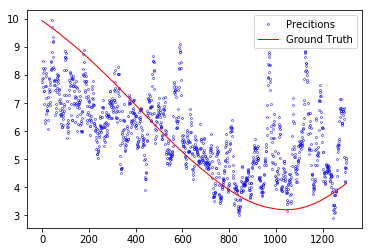

Test RMSE: 1.7254601650180923
Test  MRE: 25.600299184244694 %


In [40]:
# 100 components, full data, n_estimators = 100, reg:gamma
# preds = model.predict(np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)))
# rmse = np.sqrt(mean_squared_error(preds, Y_val)) #np.sqrt(np.mean((preds-Y_testing)**2))
# print("Val RMSE:", rmse)

## CNN-32-16
preds = model.predict(testX)#np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1)))
# preds = np.reshape(preds, (preds.shape[0],))
# print(preds.shape, testY.shape)
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(testY,'r',linewidth=1.0)
plt.legend(['Precitions', 'Ground Truth'])
plt.show()

rmse = np.sqrt(mean_squared_error(preds, testY)) #np.sqrt(np.mean((preds-Y_testing)**2))
print("Test RMSE:", rmse)
print("Test  MRE:", rmse*100.0/(np.max(testY) - np.min(testY)),"%" )

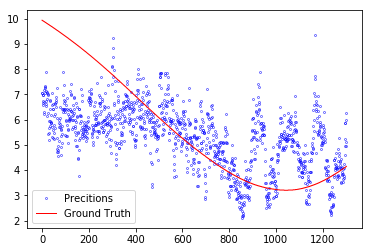

Test RMSE: 1.8648364112627602


In [23]:
# 100 components, full data, n_estimators = 100, reg:gamma
# preds = model.predict(np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)))
# rmse = np.sqrt(mean_squared_error(preds, Y_val)) #np.sqrt(np.mean((preds-Y_testing)**2))
# print("Val RMSE:", rmse)

## CNN-64-32
preds = model.predict(testX)#np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1)))
# preds = np.reshape(preds, (preds.shape[0],))
# print(preds.shape, testY.shape)
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(testY,'r',linewidth=1.0)
plt.legend(['Precitions', 'Ground Truth'])
plt.show()

rmse = np.sqrt(mean_squared_error(preds, testY)) #np.sqrt(np.mean((preds-Y_testing)**2))
print("Test RMSE:", rmse)
print("TEST MRE", rmse*100.0/(np.max(testY) - np.min(testY)) )

In [22]:
np.max(Y_training)

10.0